# Классификация изображений

In [2]:
!nvidia-smi

Mon Apr 26 09:53:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
import tensorflow.keras.models as Model
import tensorflow.keras.layers as Layer

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [4]:
!pip freeze > requirements.txt

# Основные настройки

In [5]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

In [6]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [7]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.sample(5)

,Id,Category
99,111114.jpg,0
8450,157246.jpg,5
2882,222821.jpg,1
2177,156050.jpg,1
12856,137541.jpg,8


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [9]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

В датасете представлено 10 марок машин. Распределение классов достаточно равномерное - это хорошо

In [10]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


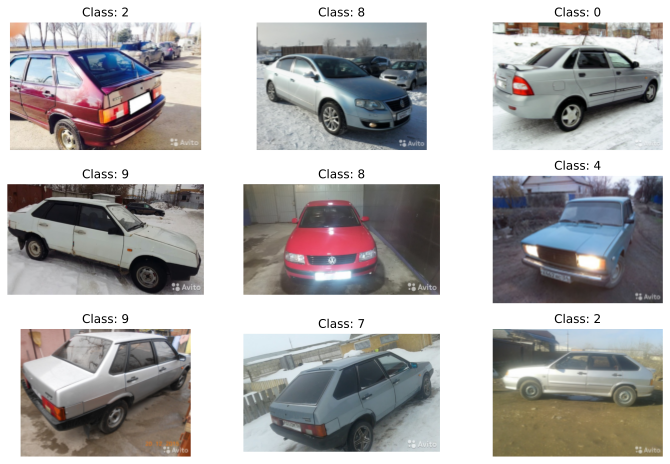

In [11]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Видим, что картинки разного размера

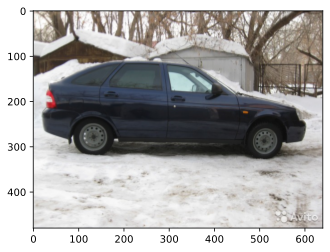

(640, 480)

In [12]:
# Посмотрим на картинку с координатами и размерами, чтобы понимать, как лучше обрабатывать и сжимать
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

### Аугментация данных

Попробуем подключить более продвинутые библиотеки аугментации изображений

In [13]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-o_1kdjhy
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-o_1kdjhy
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=2e56be904e570e31fb1547d772fa2aa924dd7b65042199df372afb99800b75c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-ve5dcxlz/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [14]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

In [15]:
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224)],
        p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

### Генерация данных

In [17]:
# Завернем наши данные в генератор:

train_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

train_datagen = train_gen.flow_from_directory(PATH+'train/', 
                                            class_mode='categorical', 
                                            batch_size=BATCH_SIZE, 
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            shuffle=True,
                                            subset='training'
                                           )
test_datagen = train_gen.flow_from_directory(PATH+'train/', 
                                             class_mode='categorical', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                            )

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


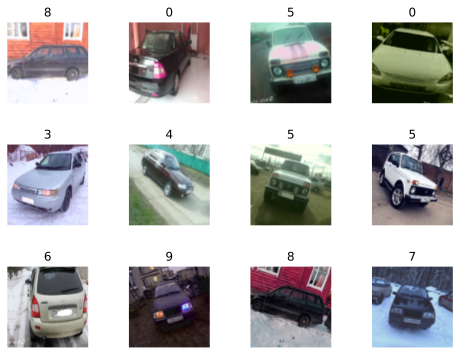

In [18]:
# посмотрим на аугментированные данные

train_datagen.show_data(rows=3, cols=4)

# Построение модели

In [19]:
# загрузим предобученную модель
# Загрузка модели efficientnet
!pip install -q efficientnet

In [20]:
import efficientnet.keras as efn 

In [21]:
base_model = efn.EfficientNetB5(weights='imagenet', 
                                include_top=False, 
                                input_shape = input_shape)

115515392/115515256 [==============================] - 2s 0us/step


In [22]:
base_model.summary()

Model: "efficientnet-b5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [23]:
base_model.trainable = False

In [24]:
model=Model.Sequential()
model.add(base_model)
model.add(Layer.GlobalAveragePooling2D())
model.add(Layer.Dense(256, 
                      activation='relu', 
                      bias_regularizer=l2(1e-4),
                      activity_regularizer=l2(1e-5)))
model.add(Layer.BatchNormalization())
model.add(Layer.Dropout(0.25))
model.add(Layer.Dense(CLASS_NUM, activation='softmax'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 527,626
Non-trainable params: 28,514,032
______________________________________

In [26]:
# проверяем слои на обучаемость
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7fbed4388690> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fbea1358890> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fbea4178cd0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fbea134ab50> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7fbea13661d0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fbee9840dd0> True


In [27]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [28]:
# Добавим ModelCheckpoint. 
# Эта функция позволяет сохранять прогресс обучения модели, 
# чтобы в нужный момент можно было его подгрузить и дообучить модель.
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 4,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [29]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)



Epoch 1/8
827/827 [==============================] - 195s 215ms/step - loss: 2.2166 - accuracy: 0.2921 - val_loss: 1.2141 - val_accuracy: 0.5746

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
827/827 [==============================] - 177s 214ms/step - loss: 1.5327 - accuracy: 0.4699 - val_loss: 1.0407 - val_accuracy: 0.6461

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
827/827 [==============================] - 177s 214ms/step - loss: 1.3586 - accuracy: 0.5306 - val_loss: 0.9613 - val_accuracy: 0.6634

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
827/827 [==============================] - 178s 215ms/step - loss: 1.2717 - accuracy: 0.5639 - val_loss: 0.9261 - val_accuracy: 0.6746

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
827/827 [==============================] - 176s 213ms/step - loss: 1.1900 - accuracy: 0.5856 - val_loss: 0.8545 - val_accuracy: 0.7129

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
827/827 [==========================

In [31]:
model.load_weights('best_model.hdf5')

In [32]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 27s 182ms/step - loss: 0.8159 - accuracy: 0.7196
Accuracy: 71.96%


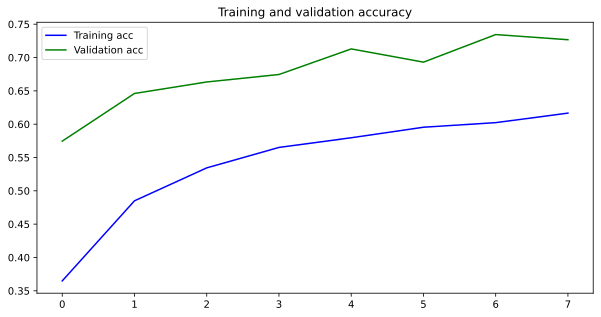

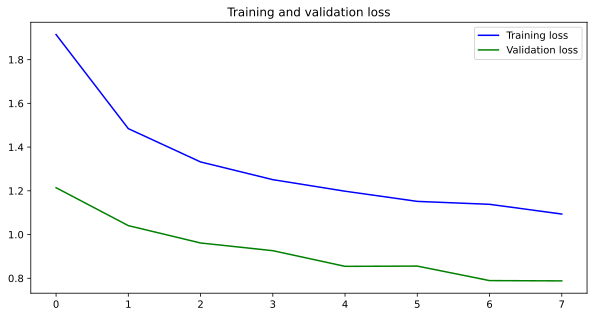

In [33]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

Шаг 2 

In [34]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [35]:
LR=0.0001
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 26,777,098
Non-trainable params: 2,264,560
____________________________________

In [37]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
827/827 [==============================] - 219s 245ms/step - loss: 1.5048 - accuracy: 0.4986 - val_loss: 0.4567 - val_accuracy: 0.8323

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
827/827 [==============================] - 198s 239ms/step - loss: 0.6146 - accuracy: 0.7813 - val_loss: 0.3082 - val_accuracy: 0.8836

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
827/827 [==============================] - 196s 237ms/step - loss: 0.4052 - accuracy: 0.8598 - val_loss: 0.2599 - val_accuracy: 0.9142

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
827/827 [==============================] - 196s 237ms/step - loss: 0.3208 - accuracy: 0.8814 - val_loss: 0.2428 - val_accuracy: 0.9108

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
827/827 [==============================] - 196s 237ms/step - loss: 0.2798 - accuracy: 0.9034 - val_loss: 0.2269 - val_accuracy: 0.9237

Epoch 00005: saving model to best_model.hdf5
Epoch 6/8
827/827 [==========================

In [38]:
model.load_weights('best_model.hdf5')

In [39]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 26s 179ms/step - loss: 0.2159 - accuracy: 0.9334
Accuracy: 93.34%


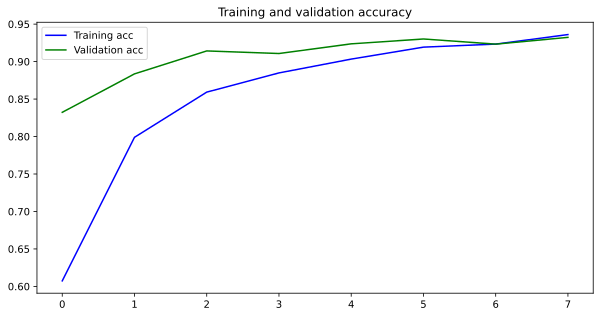

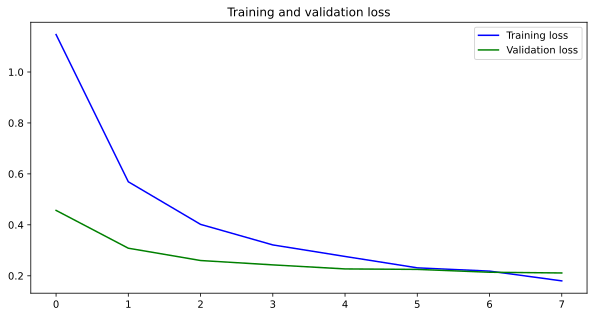

In [40]:
plot_history(history)

Шаг 3

In [41]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//4

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [42]:
LR=0.00001

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 28,603,274
Non-trainable params: 438,384
______________________________________

In [44]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
827/827 [==============================] - 232s 258ms/step - loss: 0.1879 - accuracy: 0.9330 - val_loss: 0.2096 - val_accuracy: 0.9297

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
827/827 [==============================] - 213s 257ms/step - loss: 0.1429 - accuracy: 0.9490 - val_loss: 0.1821 - val_accuracy: 0.9409

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
827/827 [==============================] - 211s 255ms/step - loss: 0.1459 - accuracy: 0.9491 - val_loss: 0.1883 - val_accuracy: 0.9362

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
827/827 [==============================] - 211s 255ms/step - loss: 0.1253 - accuracy: 0.9565 - val_loss: 0.1904 - val_accuracy: 0.9401

Epoch 00004: saving model to best_model.hdf5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
Epoch 5/8
827/827 [==============================] - 208s 252ms/step - loss: 0.1129 - accuracy: 0.9581 - val_loss: 0.1825 - val_accuracy: 0.9440

Epoch 000

In [45]:
model.load_weights('best_model.hdf5')

In [46]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 26s 176ms/step - loss: 0.1850 - accuracy: 0.9438
Accuracy: 94.38%


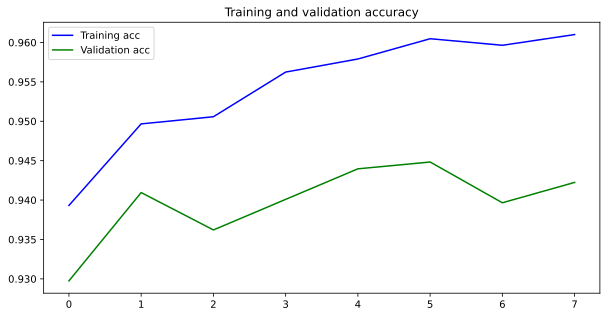

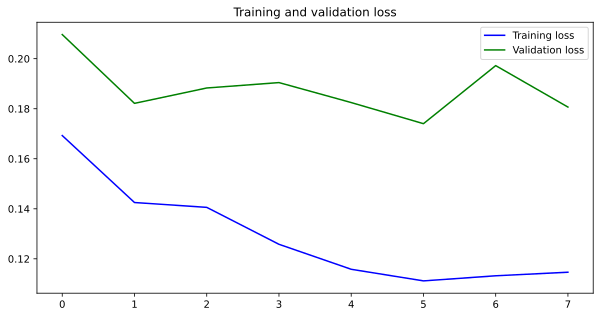

In [47]:
plot_history(history)

Шаг 4

In [48]:
base_model.trainable = True
LR=0.000001

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [49]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
827/827 [==============================] - 367s 418ms/step - loss: 0.1211 - accuracy: 0.9560 - val_loss: 0.1639 - val_accuracy: 0.9435

Epoch 00001: saving model to best_model.hdf5
Epoch 2/8
827/827 [==============================] - 341s 412ms/step - loss: 0.1311 - accuracy: 0.9504 - val_loss: 0.1734 - val_accuracy: 0.9474

Epoch 00002: saving model to best_model.hdf5
Epoch 3/8
827/827 [==============================] - 341s 412ms/step - loss: 0.1174 - accuracy: 0.9605 - val_loss: 0.1598 - val_accuracy: 0.9478

Epoch 00003: saving model to best_model.hdf5
Epoch 4/8
827/827 [==============================] - 339s 409ms/step - loss: 0.1290 - accuracy: 0.9525 - val_loss: 0.1642 - val_accuracy: 0.9435

Epoch 00004: saving model to best_model.hdf5
Epoch 5/8
827/827 [==============================] - 340s 411ms/step - loss: 0.1169 - accuracy: 0.9579 - val_loss: 0.1718 - val_accuracy: 0.9444

Epoch 00005: saving model to best_model.hdf5

Epoch 00005: ReduceLROnPlateau reducing lear

In [50]:
model.load_weights('best_model.hdf5') 

In [51]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 25s 171ms/step - loss: 0.1697 - accuracy: 0.9472
Accuracy: 94.72%


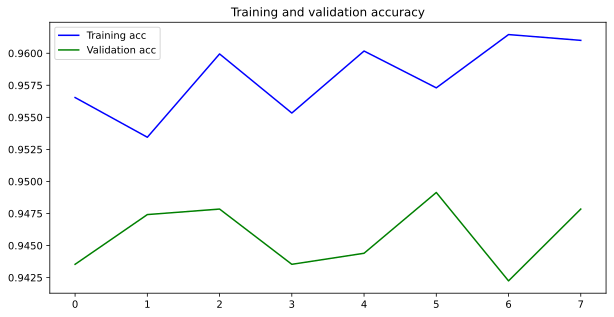

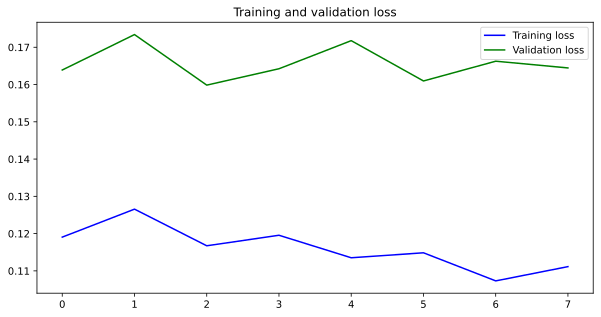

In [52]:
plot_history(history)

Предсказание после fine-tuning

In [53]:
test_gen = ImageDataAugmentor(rescale=1./255)
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=PATH+'test_upload/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

Found 6675 validated image filenames.


In [54]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, 
                                      steps=len(test_sub_generator), 
                                      verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

418/418 [==============================] - 54s 122ms/step


In [55]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')

submission.to_csv('submission.csv', index=False)

Попробуем увеличить IMG_SIZE

In [56]:
EPOCHS               = 6
BATCH_SIZE           = 4 
LR                   = 1e-4

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [57]:
AUGMENTATIONS = A.Compose([
    #A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.HorizontalFlip(p=0.5),
    #A.HueSaturationValue(p=0.5)
])

train_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

train_datagen = train_gen.flow_from_directory(PATH+'train/', 
                                            class_mode='categorical', 
                                            batch_size=BATCH_SIZE, 
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            shuffle=True,
                                            subset='training'
                                           )
test_datagen = train_gen.flow_from_directory(PATH+'train/', 
                                             class_mode='categorical', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                            )

test_gen = ImageDataAugmentor(rescale=1./255)
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=PATH+'test_upload/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [58]:
base_model = efn.EfficientNetB5(weights='imagenet', 
                            include_top=False, 
                            input_shape = input_shape)

In [59]:
base_model.trainable = True

In [60]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])
model.load_weights('best_model.hdf5')

In [61]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/6
3308/3308 [==============================] - 1767s 528ms/step - loss: 0.5139 - accuracy: 0.8410 - val_loss: 0.1250 - val_accuracy: 0.9639

Epoch 00001: saving model to best_model.hdf5
Epoch 2/6
3308/3308 [==============================] - 1744s 527ms/step - loss: 0.2777 - accuracy: 0.9143 - val_loss: 0.1240 - val_accuracy: 0.9712

Epoch 00002: saving model to best_model.hdf5
Epoch 3/6
3308/3308 [==============================] - 1744s 527ms/step - loss: 0.2258 - accuracy: 0.9302 - val_loss: 0.1073 - val_accuracy: 0.9682

Epoch 00003: saving model to best_model.hdf5
Epoch 4/6
3308/3308 [==============================] - 1753s 530ms/step - loss: 0.2009 - accuracy: 0.9363 - val_loss: 0.1200 - val_accuracy: 0.9669

Epoch 00004: saving model to best_model.hdf5
Epoch 5/6
3308/3308 [==============================] - 1742s 527ms/step - loss: 0.1610 - accuracy: 0.9500 - val_loss: 0.1344 - val_accuracy: 0.9678

Epoch 00005: saving model to best_model.hdf5

Epoch 00005: ReduceLROnPlatea

In [62]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 54s 93ms/step - loss: 0.1052 - accuracy: 0.9738
Accuracy: 97.38%


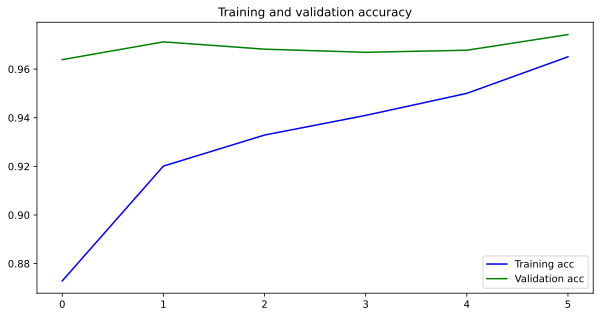

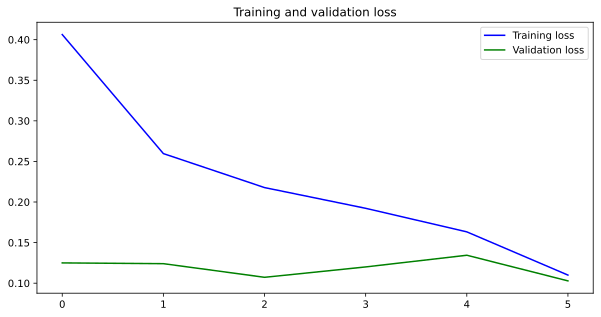

In [63]:
plot_history(history)

In [64]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

1669/1669 [==============================] - 149s 88ms/step


In [65]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')

In [66]:
submission.to_csv('submission_512_img_size.csv', index=False)

# Итоги

В проекте использовал:
- transfer learning и fine-tuning (обучение головы -> 50% разморозка весов предобученной модели -> 75% разморозка -> 100% разморозка)
- дополнительные функции callback в Keras
- настройка LR, подбор остальных переменных (размер картинки, батч, кол-во эпох)
- применен способ заполнения пропусков c помощью ImageDataAugmentor с использованием библиотеки аугментации изображений albumentations
- добавлена Batch Normalization в архитектуре “головы” модели
- SOTA архитектура сетей - Xception, EfficientNetB5

# Что можно сделать, чтобы улучшить результат:

* Настройте LR, optimizer, loss
* Добавьте TTA (Test Time Augmentation)
* ОБогащение датасетов, еще поэксперементировать с кол-вом эпох, батчей и картинкой
* Попробовать другие предоученные сети